In [1]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_csv('/Users/daviderickson/projects/datasf/data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

In [21]:
df.shape

(2215024, 33)

In [10]:
df.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,...,:@computed_region_n4xg_c4py,:@computed_region_4isq_27mq,:@computed_region_fcz8_est8,:@computed_region_pigm_ib2e,:@computed_region_9jxd_iqea,:@computed_region_6pnf_4xz7,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_2dwj_jsy4
0,180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.411912,...,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN
1,180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.419258,...,1.0,NaN,1.0,NaN,8.0,2.0,1.0,1.0,1.0,NaN
2,180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,...,NaN,15.0,3.0,15.0,NaN,2.0,NaN,NaN,3.0,NaN
3,180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,...,NaN,15.0,3.0,15.0,NaN,2.0,NaN,NaN,3.0,NaN
4,180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,...,NaN,15.0,3.0,15.0,NaN,2.0,NaN,NaN,3.0,NaN


In [20]:
print(df.columns)

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       ':@computed_region_yftq_j783', ':@computed_region_p5aj_wyqh',
       ':@computed_region_rxqg_mtj9', ':@computed_region_bh8s_q3mv',
       ':@computed_region_fyvs_ahh9', ':@computed_region_9dfj_4gjx',
       ':@computed_region_n4xg_c4py', ':@computed_region_4isq_27mq',
       ':@computed_region_fcz8_est8', ':@computed_region_pigm_ib2e',
       ':@computed_region_9jxd_iqea', ':@computed_region_6pnf_4xz7',
       ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi',
       ':@computed_region_nqbw_i6c3', ':@computed_region_2dwj_jsy4'],
      dtype='object')


In [6]:
df.describe()

,IncidntNum,X,Y,PdId,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,:@computed_region_yftq_j783,:@computed_region_p5aj_wyqh,...,:@computed_region_n4xg_c4py,:@computed_region_4isq_27mq,:@computed_region_fcz8_est8,:@computed_region_pigm_ib2e,:@computed_region_9jxd_iqea,:@computed_region_6pnf_4xz7,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_2dwj_jsy4
count,2.215024e+06,2.215024e+06,2.215024e+06,2.215024e+06,2.208947e+06,2.213912e+06,2.214363e+06,2.213967e+06,2.209444e+06,2.213501e+06,...,320205.0,564496.000000,473794.000000,570165.000000,565021.000000,2.213967e+06,340938.0,341126.0,503448.000000,119091.000000
mean,1.040728e+08,-1.224229e+02,3.777076e+01,1.040728e+13,5.220508e+01,4.874528e+00,6.832845e+00,2.187302e+01,8.605482e+00,5.086868e+00,...,1.0,14.106791,2.155272,13.912473,6.297216,1.597475e+00,1.0,1.0,2.322856,36.712774
std,4.612827e+07,2.983459e-02,4.203596e-01,4.612827e+12,3.158740e+01,2.782250e+00,3.394744e+00,1.272125e+01,4.276287e+00,2.990329e+00,...,0.0,6.116613,1.182136,6.299596,2.516868,4.904066e-01,0.0,0.0,1.328072,10.222076
min,3.979000e+03,-1.225136e+02,3.770788e+01,3.979630e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.000000,2.000000
25%,6.124170e+07,-1.224332e+02,3.775302e+01,6.124170e+12,2.500000e+01,3.000000e+00,3.000000e+00,9.000000e+00,5.000000e+00,2.000000e+00,...,1.0,10.000000,1.000000,9.000000,5.000000,1.000000e+00,1.0,1.0,1.000000,35.000000
50%,1.011558e+08,-1.224166e+02,3.777542e+01,1.011558e+13,4.400000e+01,5.000000e+00,8.000000e+00,2.100000e+01,9.000000e+00,4.000000e+00,...,1.0,15.000000,3.000000,15.000000,6.000000,2.000000e+00,1.0,1.0,3.000000,35.000000
75%,1.409256e+08,-1.224069e+02,3.778448e+01,1.409256e+13,8.400000e+01,7.000000e+00,1.000000e+01,3.400000e+01,1.300000e+01,8.000000e+00,...,1.0,18.000000,3.000000,18.000000,7.000000,2.000000e+00,1.0,1.0,3.000000,35.000000
max,9.915824e+08,-1.205000e+02,9.000000e+01,9.915824e+13,1.170000e+02,1.000000e+01,1.100000e+01,4.100000e+01,1.500000e+01,1.000000e+01,...,1.0,25.000000,5.000000,25.000000,15.000000,2.000000e+00,1.0,1.0,5.000000,80.000000


In [7]:
corr = df.corr()

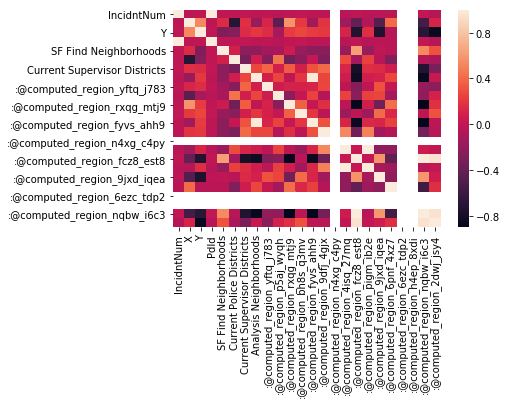

In [8]:
sns.heatmap(corr)

In [ ]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)
print(df.dropna(axis=0).shape)

'IncidntNum',  'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
    
    
df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution',])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
pca.fit(df1)
X_pca = pca.fit(df1).transform(df1)

In [23]:
df[['Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods']]

,Address,X,Y,Location,PdId,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,700 Block of TEHAMA ST,-122.411912,37.775207,"(37.77520656149669, -122.41191202732877)",18036228907023,32.0,1.0,10.0,34.0
1,MARKET ST / SOUTH VAN NESS AV,-122.419258,37.775146,"(37.77514629165388, -122.41925789481357)",18036094864020,32.0,1.0,10.0,20.0
2,CAPP ST / 21ST ST,-122.417813,37.757101,"(37.757100579642824, -122.41781255878655)",18036087926150,53.0,3.0,2.0,20.0
3,CAPP ST / 21ST ST,-122.417813,37.757101,"(37.757100579642824, -122.41781255878655)",18036087965010,53.0,3.0,2.0,20.0
4,CAPP ST / 21ST ST,-122.417813,37.757101,"(37.757100579642824, -122.41781255878655)",18036087965015,53.0,3.0,2.0,20.0
5,700 Block of SHOTWELL ST,-122.415617,37.756414,"(37.75641376904809, -122.41561725232026)",18036082965016,53.0,3.0,2.0,20.0
6,0 Block of 6TH ST,-122.410042,37.781954,"(37.781953653725715, -122.41004163181597)",18036083503074,32.0,5.0,10.0,34.0
7,0 Block of 6TH ST,-122.410042,37.781954,"(37.781953653725715, -122.41004163181597)",18036083516710,32.0,5.0,10.0,34.0
8,1500 Block of HAIGHT ST,-122.447761,37.769846,"(37.76984648754153, -122.44776112231955)",18036079417030,25.0,7.0,11.0,3.0
9,1500 Block of HAIGHT ST,-122.447761,37.769846,"(37.76984648754153, -122.44776112231955)",18036079462050,25.0,7.0,11.0,3.0


In [30]:
df.count()['SF Find Neighborhoods']

2208947

In [48]:
cols_list = ['Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods']
for col in cols_list:
    series = df[col]
    series.unique()
    print(col, '- unique entries - ', len(series.unique()))

Address - unique entries -  25147
X - unique entries -  60620
Y - unique entries -  58674
Location - unique entries -  61430
PdId - unique entries -  2215024
SF Find Neighborhoods - unique entries -  118
Current Police Districts - unique entries -  11
Current Supervisor Districts - unique entries -  12
Analysis Neighborhoods - unique entries -  42


In [37]:
len(df['SF Find Neighborhoods'].unique())

118

In [44]:
df['SF Find Neighborhoods']

0           32.0
1           32.0
2           53.0
3           53.0
4           53.0
5           53.0
6           32.0
7           32.0
8           25.0
9           25.0
10          53.0
11          53.0
12          20.0
13         108.0
14          32.0
15          32.0
16          20.0
17          32.0
18          53.0
19          53.0
20           5.0
21          28.0
22          53.0
23          53.0
24          53.0
25          32.0
26          37.0
27          32.0
28          34.0
29          32.0
           ...  
2214994    106.0
2214995     95.0
2214996     83.0
2214997     32.0
2214998    104.0
2214999     86.0
2215000     86.0
2215001     32.0
2215002     53.0
2215003     66.0
2215004     53.0
2215005     32.0
2215006     91.0
2215007     87.0
2215008      8.0
2215009      8.0
2215010      8.0
2215011     32.0
2215012     27.0
2215013     95.0
2215014     53.0
2215015     83.0
2215016     90.0
2215017     20.0
2215018     32.0
2215019     15.0
2215020     37.0
2215021    102

In [31]:
df.count()

IncidntNum                      2215024
Category                        2215024
Descript                        2215024
DayOfWeek                       2215024
Date                            2215024
Time                            2215024
PdDistrict                      2215023
Resolution                      2215024
Address                         2215024
X                               2215024
Y                               2215024
Location                        2215024
PdId                            2215024
SF Find Neighborhoods           2208947
Current Police Districts        2213912
Current Supervisor Districts    2214363
Analysis Neighborhoods          2213967
:@computed_region_yftq_j783     2209444
:@computed_region_p5aj_wyqh     2213501
:@computed_region_rxqg_mtj9     2214363
:@computed_region_bh8s_q3mv     2214529
:@computed_region_fyvs_ahh9     2213967
:@computed_region_9dfj_4gjx      548407
:@computed_region_n4xg_c4py      320205
:@computed_region_4isq_27mq      564496
